<a href="https://colab.research.google.com/github/heshumi/NNTI-WS2021-NLP-Project/blob/main/Task%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Task 2a) Binary neural sentiment classifier for Hindi dataset using pretrained Hindi word2vec model trained from task 1.

**Note:** keep/upload the folowing files in the runtime before executing the notebook. 
`hindi_dataset.tsv`, `bengali_hatespeech.csv`, `bengali_hatespeech_sampled.csv`, `stopwords-bn.txt`, `stopwords-en.txt`, `stopwords-hi.txt`, `Word2Vec-hindi.model`, `Word2Vec-bg.model`, `task2_utils.py`. Note that,
`task2_utils.py` contains all the necessary classes and functions that are required in this task 2 and those are separated as per the general guidlines of the project handout.

#### Importing the packages

In [ ]:
# Imports
import pandas as pd
import numpy as np
from math import sqrt
import random
import time
import copy
import string
import torch.nn as nn
import torch                                                                                                                                                                                                                                                                                                                                                                            
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt
from task2_utils import * #separate .py file for functions and classes as instructed

#### Reading Hindi dataset for sentiment classification. Word2vec model for Hindi dataset is already trained in task 1 and will be loaded in a further cell. 

In [ ]:
data_hindi = pd.read_csv('hindi_dataset.tsv', sep='\t', usecols=['text', 'task_1'])
dev_hindi = data_hindi
dev_hindi.head()

,text,task_1
0,"बांग्लादेश की शानदार वापसी, भारत को 314 रन पर ...",NOT
1,सब रंडी नाच देखने मे व्यस्त जैसे ही कोई #शांती...,HOF
2,तुम जैसे हरामियों के लिए बस जूतों की कमी है शु...,HOF
3,"बीजेपी MLA आकाश विजयवर्गीय जेल से रिहा, जमानत ...",NOT
4,चमकी बुखार: विधानसभा परिसर में आरजेडी का प्रदर...,NOT


#### Preprocess the dataset. Here we remove the punctuations, stopwords and other non-influential words and symbols like 'http' and '@' from the beginning of a word and make word list candidates from the sentences. 

In [ ]:
with open('stopwords-hi.txt', 'r') as f:
  stopwords_hi = set(f.read().split())

punct = ':;?!-—-\"\'|।()[]{},./\\“'
dev_hindi['text'] = dev_hindi['text'].apply(lambda x: preprocess(x, punct, stopwords_hi))
dev_hindi['text'][:5]

0    [बांग्लादेश, शानदार, वापसी, भारत, 314, रोका, #...
1    [रंडी, नाच, देखने, व्यस्त, #शांतीदूत, होगा, #र...
2    [तुम, हरामियों, जूतों, कमी, शुक्र, तुम्हारी, ल...
3    [बीजेपी, mla, आकाश, विजयवर्गीय, जेल, रिहा, जमा...
4    [चमकी, बुखार, विधानसभा, परिसर, आरजेडी, प्रदर्श...
Name: text, dtype: object

#### Build the vocabulary avaialable in the dataset

In [ ]:
hindi_V = build_vocab(dev_hindi)
summ = sum(hindi_V.values())
len(hindi_V)

19356

#### Developing a dictionary that represents the one hot encoding of the words in the vocabulary

In [ ]:
pad = 1
onehot_dict_hindi= build_onehot(hindi_V, pad)

In [ ]:
# print one hot of padding
print(onehot_dict_hindi[' '])

[0. 0. 0. ... 0. 0. 1.]


#### Getting the insigths of the sentences in sense of the number of words in a sentence. 

count    4665.000000
mean       16.403859
std         8.855921
min         0.000000
25%         9.000000
50%        15.000000
75%        23.000000
max        61.000000
dtype: float64

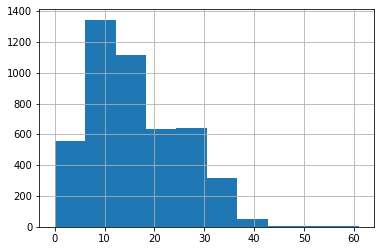

In [ ]:
text_len = [len(x) for x in dev_hindi['text']]
ax = pd.Series(text_len).hist()
fig = ax.get_figure()
fig.savefig('Hindi_dataset_histogram.png')
pd.Series(text_len).describe()

#### From the Histogram above we see that 75% of the sentences are covered with 23 being the size of the words in sentences. We select 35 as the maximum number of words in a sentence considering factor like outliers.

#### Set the hyperparameters for Sentiment classification of Hindi Dataset

In [ ]:
# Set hyperparameters
batch_size = 64
min_sen_length=35
epochs = 10
embedding_size = 300
input_size = len(hindi_V) #For embedding 


#### Then we create a custom Hindi dataset and data loader to train the binary classifier

In [ ]:
dataset_hindi = MyDataset(dev_hindi, min_sen_length, onehot_dict_hindi)

#### Split dataset to train, validation and test set and define Data loader for Hindi dataset

In [ ]:
train_size, val_size, test_size = int(0.7 * len(dataset_hindi)), int(0.15 * len(dataset_hindi)+1), int(0.15 * len(dataset_hindi)+1)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset_hindi, [train_size, val_size, test_size])
trainloader_hindi = DataLoader(train_dataset, batch_size= batch_size, shuffle = False, num_workers=0)
valloader_hindi = DataLoader(val_dataset, batch_size= batch_size, shuffle = False, num_workers=0)
testloader_hindi = DataLoader(test_dataset, batch_size= batch_size, shuffle = False, num_workers=0)
i1, l1 = next(iter(trainloader_hindi))
print(i1.shape)

torch.Size([64, 35, 19357])


#### Create same Word2Vec model architecture as defined in task 1. We are not gonna train the Word2Vec model again rather will load the Hindi Word2Vec model as instructed in the next cell. 

In [ ]:
word2vec_model = Word2Vec(input_size, embedding_size)  

#### Load the pretrained word2vec model. Also, add a new column to the first hidden layer for allwoing weights of padding. (Please make sure the pretrained model from task 1 'word2vec_model' is avaialable in the runtime)

In [ ]:
# word2vec_model.cuda()
word2vec_model.load_state_dict(torch.load('/content/Word2Vec-hindi.model',  map_location='cpu'))
word2vec_model.eval()

# Add a column to the first hidden layer matrix of the word2vec model for the padding embedding.
embeddings = torch.cat((word2vec_model.fc1.weight.detach(), torch.zeros(embedding_size).unsqueeze(1)), dim = 1) # init the padding embedding by zeros
biases = word2vec_model.fc1.bias.detach()

In [ ]:
embeddings.shape

torch.Size([300, 19357])

#### Set more hyperparameters to train binary sentiment classifier

In [ ]:
n_filters = 35
filter_sizes = [8,5,3]
output_dim = 1
dropout = 0.5
N_EPOCHS = 50 #with early stopping

#### Convolution based model architecture for Hindi sentiment classification

#### Create CNN model instance by importing CNN_HINDI defined in task2_utils file.

In [ ]:
cnn = CNN_HINDI(input_size, embedding_size, n_filters, filter_sizes, output_dim, dropout)
cnn.double()

CNN_HINDI(
  (embedding): Linear(in_features=19357, out_features=300, bias=True)
  (conv_0): Conv2d(1, 35, kernel_size=(8, 300), stride=(1, 1))
  (conv_1): Conv2d(1, 35, kernel_size=(5, 300), stride=(1, 1))
  (conv_2): Conv2d(1, 35, kernel_size=(3, 300), stride=(1, 1))
  (fc): Linear(in_features=105, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

#### Copy the pre-trained embeddings weights and biases as the Hindi CNN model's embedding layer

In [ ]:
cnn.embedding.bias.data.copy_(biases)
cnn.embedding.weight.data.copy_(embeddings)

tensor([[ -6.2279,  -2.2322,  -6.3548,  ...,   0.6193,   6.5156,   0.0000],
        [-12.7375, -10.8961,   1.2383,  ...,   2.8030,  13.6377,   0.0000],
        [ -7.9884, -32.7764, -14.5382,  ..., -18.0882, -19.6158,   0.0000],
        ...,
        [ -2.6832,  -0.8967,   1.0232,  ...,   0.6459,   0.0771,   0.0000],
        [ -6.4597,  -6.6789,  -6.1366,  ...,   9.5053,  -5.5762,   0.0000],
        [ -7.6579,  -5.1581,  -2.7021,  ...,  -1.4723,   4.6150,   0.0000]],
       dtype=torch.float64)

#### Define optimizer and criterion for sentiment classification training

In [ ]:
optimizer = optim.Adam(cnn.parameters())

criterion = nn.BCEWithLogitsLoss()


#### Training the binary sentiment classification model

In [ ]:
# Keeping loss and accuracy history of epochs for visualiztion
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

# Counter for Early stopping. Stops if no better loss for validation is achieved in 4 consecutive epochs.
stop_criterion = 0
best_valid_loss = float('inf') #Initially sets to infinity

for epoch in range(N_EPOCHS):
    #start time of the epoch
    start_time = time.time()
    
    train_loss, train_acc = train_cnn(cnn, trainloader_hindi, optimizer, criterion)
    valid_loss, valid_acc = evaluate_cnn(cnn, valloader_hindi, criterion)
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    val_loss_history.append(valid_loss)
    val_acc_history.append(valid_acc)

    #End time
    end_time = time.time()
    # calculate elapsed time in mins and seconds
    required_time = end_time - start_time
    mins = int(required_time / 60)
    secs = int(required_time - (mins * 60))
    
    stop_criterion += 1
    
    #Saving the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(cnn.state_dict(), 'cnn_hindi_model.pt')
        best_model_hindi = copy.deepcopy(cnn)
        stop_criterion = 0
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {mins}m {secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    if stop_criterion == 4:
      break

Epoch: 01 | Epoch Time: 1m 43s
	Train Loss: 3.712 | Train Acc: 57.33%
	 Val. Loss: 0.574 |  Val. Acc: 69.61%
Epoch: 02 | Epoch Time: 1m 43s
	Train Loss: 0.607 | Train Acc: 64.66%
	 Val. Loss: 0.541 |  Val. Acc: 72.60%
Epoch: 03 | Epoch Time: 1m 45s
	Train Loss: 0.574 | Train Acc: 68.51%
	 Val. Loss: 0.548 |  Val. Acc: 74.57%
Epoch: 04 | Epoch Time: 1m 44s
	Train Loss: 0.536 | Train Acc: 70.73%
	 Val. Loss: 0.509 |  Val. Acc: 75.74%
Epoch: 05 | Epoch Time: 1m 43s
	Train Loss: 0.508 | Train Acc: 73.35%
	 Val. Loss: 0.498 |  Val. Acc: 75.16%
Epoch: 06 | Epoch Time: 1m 39s
	Train Loss: 0.525 | Train Acc: 71.33%
	 Val. Loss: 0.491 |  Val. Acc: 74.58%
Epoch: 07 | Epoch Time: 1m 37s
	Train Loss: 0.502 | Train Acc: 74.34%
	 Val. Loss: 0.495 |  Val. Acc: 76.41%
Epoch: 08 | Epoch Time: 1m 38s
	Train Loss: 0.491 | Train Acc: 71.81%
	 Val. Loss: 0.470 |  Val. Acc: 78.56%
Epoch: 09 | Epoch Time: 1m 37s
	Train Loss: 0.471 | Train Acc: 75.54%
	 Val. Loss: 0.457 |  Val. Acc: 77.58%
Epoch: 10 | Epoch T

#### Visualize Loss and Accuracy for the model

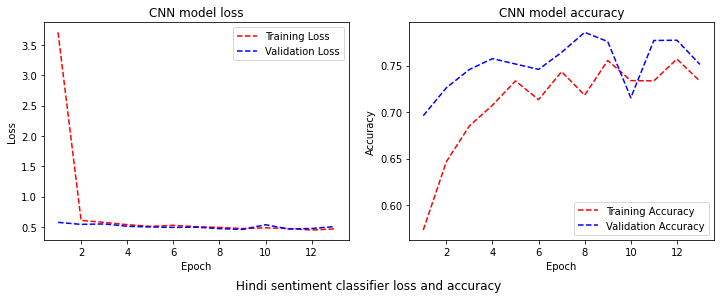

In [ ]:
epoch_count = list(range(1, len(train_loss_history)+1))
x1 = epoch_count
x2 = epoch_count
y1_train = train_loss_history
y1_val = val_loss_history
y2_train = train_acc_history
y2_val = val_acc_history

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
axes[0].plot(x1, y1_train, 'r--')
axes[0].plot(x1, y1_val, 'b--')
axes[0].legend(['Training Loss', 'Validation Loss'])
axes[0].set(xlabel='Epoch', ylabel='Loss')
axes[0].set_title('CNN model loss')
axes[1].plot(x1, y2_train, 'r--')
axes[1].plot(x1, y2_val, 'b--')
axes[1].legend(['Training Accuracy', 'Validation Accuracy'])
axes[1].set(xlabel='Epoch', ylabel='Accuracy')
axes[1].set_title('CNN model accuracy')
fig.suptitle('Hindi sentiment classifier loss and accuracy', y=-0.01)
plt.savefig('cnn.png')

#### Evaluate model on test data

In [ ]:
best_model_hindi.eval()
test_acc_hindi, precision, recall, f1_score = evaluate_sentiment_classifier(best_model_hindi, testloader_hindi)
print(f'Accuracy of Binary sentiment classification for Hindi test dataset: {test_acc_hindi*100:.2f}%')
print(f'Precision of Hindi test dataset: {precision*100:.2f}%')
print(f'Recall of Hindi test dataset: {recall*100:.2f}%')
print(f'F1 score for Hindi test dataset: {f1_score*100:.2f}%')

Accuracy of Binary sentiment classification for Hindi test dataset: 77.59%
Precision of Hindi test dataset: 86.54%
Recall of Hindi test dataset: 71.46%
F1 score for Hindi test dataset: 78.28%


## Task 2b) Preprocess Bengali dataset to make Approximately equal size in sense of size and class distribution as Hindi Dataset

**MUST READ**
#### If you want to sample bengali dataset, then you have to train the word2vec for Bengali dataset again which requires a lot of time and memory that we trained on clusters. That will make `train_bg_word2vec` flag to 1 that will eventually force to train the word2vec for bengali datset. Initailly the flag is set to 0 to load the presampled bengali data and presampled bengali embedding. **Set the value of `train_bg_word2vec = 1` only and only if you want to train word2vec for Bengali dataset**

In [ ]:
# keep it 0 if you don't want to train word2vec for bengali dataset once again that will take hours.
train_bg_word2vec = 0

#### Loading the already sampled Bengali dataset if train_bg_word2vec = 0 else sample again and you may need to train word2vec for Bengali dataeset if vocabulary size mismatch due to random sampling(though seed is used)

In [ ]:
if train_bg_word2vec==0:
  data = pd.read_csv('bengali_hatespeech_sampled.csv', usecols=['text', 'task_1'])
  dev_bg = data
  print(dev_bg.head())
else:
  df = pd.read_csv('bengali_hatespeech.csv', usecols=['sentence', 'hate'])
  #split data classes
  data_hate = df.iloc[:10000]
  data_not = df.iloc[-20000:]
  data_hate_sampled = data_hate.sample(n = 2500, random_state=1) 
  data_not_sampled = data_not.sample(n = 2200, random_state=1) 
  data_concat = pd.concat([data_hate_sampled, data_not_sampled], ignore_index=True)
  dev = data_concat.sample(frac=1).reset_index(drop=True)
  dev.columns=['text', 'task_1']
  dev['task_1'] = dev['task_1'].replace([1],'HOF')
  dev['task_1'] = dev['task_1'].replace([0],'NOT')
  dev_bg = dev
  dev.to_csv('bengali_hatespeech_sampled.csv')
  print(dev_bg.head())

                                                text task_1
0  বিশ্বাস করেন ভাই এক হাজারের উপরে কমেন্টস দেখলা...    NOT
1       ভাই এসব কথা ভালো না আপনে কি মানুষ না আর কিচো    NOT
2  কাওয় কাদের মরলে কুততা যবে করে জানোয়ার দের খাওয়...    HOF
3  এখনো সে ওই পদে বহাল কেনো আছে জাতি জানতে চাই আম...    NOT
4                          এটা তো একটা ছাগলের বাচ্চা    HOF


#### Preprocess the Bengali dataset. Here we remove the punctuations, stopwords and other non-influential words and symbols like 'http' and '@' from the beginning of a word and make word list candidates from the sentences. 

In [ ]:

with open('stopwords-hi.txt', 'r') as f:
  stopwords_hi = f.read().split()

with open('stopwords-bn.txt', 'r') as f:
  stopwords_bn = f.read().split()

with open('stopwords-en.txt', 'r') as f:
  stopwords = set(f.read().split() + stopwords_hi + stopwords_bn)

punct = ':;?!-—-\"\'|।()[]{},./\\“'
dev_bg['text'] = dev_bg['text'].apply(lambda x: preprocess(x, punct, stopwords))
dev_bg['text'][:5]

0    [বিশ্বাস, ভাই, হাজারের, কমেন্টস, দেখলাম, বিচার...
1             [ভাই, এসব, কথা, ভালো, আপনে, মানুষ, কিচো]
2    [কাওয়, কাদের, মরলে, কুততা, যবে, জানোয়ার, দের, ...
3    [এখনো, পদে, বহাল, কেনো, জাতি, চাই, জামালপুরের,...
4                               [একটা, ছাগলের, বাচ্চা]
Name: text, dtype: object

#### Build the vocabulary avaialable in the dataset

In [ ]:
bg_V = build_vocab(dev_bg)
summ = sum(bg_V.values())
len(bg_V)

14324

#### Developing a dictionary that represents the one hot encoding of the words in the vocabulary

In [ ]:
if train_bg_word2vec==0: #padding is 1 when we don't want to train word2vec but will load it later
  pad = 1
  onehot_dict_bg = build_onehot(bg_V, pad)
else:
  pad = 0
  onehot_dict_bg = build_onehot(bg_V, pad)


#### Set hyperparameters for training word2vec model for Bengali dataset

In [ ]:
# Set hyperparameters
window_size = 5
embedding_size = 300
input_size = len(bg_V) # Onehot vector length
batch_size = 50

# More hyperparameters
learning_rate = 0.05
epochs = 100

#### Create Bengali dataset instance for wor2vec and use collate function for batches

In [ ]:
dataset_bg = BengaliDataset(dev_bg['text'], window_size, bg_V, summ, onehot_dict_bg)
dataloader = DataLoader(dataset_bg, collate_fn = my_collate, batch_size= batch_size, shuffle = False, num_workers=0)

#### Create word2vec model instance for Bengali if you want to train the model. 

In [ ]:
word2vec_bg_model = Word2Vec(input_size, embedding_size)
if train_bg_word2vec==1:
  print(word2vec_bg_model.fc1.weight.shape)
  word2vec_bg_model.double()
  nn.init.uniform_(word2vec_bg_model.fc1.weight)
  nn.init.uniform_(word2vec_bg_model.fc2.weight)

#### Define optimizer and loss for Word2Vec

In [ ]:
# Define optimizer and loss
optimizer = torch.optim.Adam(word2vec_bg_model.parameters(), lr = learning_rate)

criterion = nn.CosineEmbeddingLoss()

## Task 2c) Bengali Embedding  
#### Run the below cell to train the word2vec model. It will take hours to completely train. If training word2vec for Bengali dataset is set to 1 then it will train otherwise, already trained model will be loaded 

In [ ]:
if train_bg_word2vec==1: #For training
  train(epochs, dataloader, word2vec_bg_model, criterion, optimizer)
  print("Training finished")
  torch.save(model.state_dict(), 'Word2Vec-bg.model')

else:           #for loading already trained word2vec model 'Word2Vec-bg.model' that should be available in the runtime
  word2vec_bg_model = Word2Vec(input_size, embedding_size) 
  word2vec_bg_model.load_state_dict(torch.load('/content/Word2Vec-bg.model',  map_location='cpu'))
  word2vec_bg_model.eval()
  # Add a column to the first hidden layer matrix of the word2vec model for the padding embedding.
  embeddings = torch.cat((word2vec_bg_model.fc1.weight.detach(), torch.zeros(embedding_size).unsqueeze(1)), dim = 1) # init the padding embedding by zeros
  biases = word2vec_bg_model.fc1.bias.detach()


## Task 2d) Part-0: Build a Bengali sentiment classifier with Bengali embedding 

#### One hot encoding with padding 

In [ ]:
pad = 1
onehot_dict_bg = build_onehot(bg_V, pad)
print(onehot_dict_bg[' '])

[0. 0. 0. ... 0. 0. 1.]


#### Getting the insigths of the sentences in sense of the number of words in a sentence for bengali Dataset

count    4700.000000
mean        9.754043
std        14.246602
min         0.000000
25%         4.000000
50%         6.000000
75%        11.000000
max       328.000000
dtype: float64

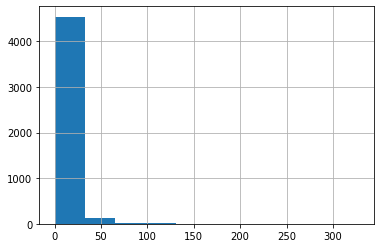

In [ ]:
text_len = [len(x) for x in dev_bg['text']]
ax = pd.Series(text_len).hist()
fig = ax.get_figure()
fig.savefig('Bengali_dataset_histogram.png')
pd.Series(text_len).describe()

#### From the Histogram above we see that 75% of the sentences are covered with 11 being the size of the words in sentences. We select 20 as the maximum number of words in a sentence considering factor like outliers for Bengali dataset.

#### Set hyperparameters for sentiment analysis on bengali data using already trained hindi model

In [ ]:
# Set hyperparameters
batch_size = 64
min_sen_length = 20
embedding_size = 300
input_size = len(bg_V)
output_dim = 1
dropout = 0.5
n_filters = 35
filter_sizes = [8,5,3]

#### We create a custom Bengali dataset and data loader to train the binary classifier

In [ ]:
dataset_bg = MyDataset(dev_bg, min_sen_length, onehot_dict_bg)

In [ ]:
train_size, val_size, test_size = int(0.7 * len(dataset_bg)), int(0.15 * len(dataset_bg)), int(0.15 * len(dataset_bg))
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset_bg, [train_size, val_size, test_size])
trainloader = DataLoader(train_dataset, batch_size= batch_size, shuffle = False, num_workers=0)
valloader = DataLoader(val_dataset, batch_size= batch_size, shuffle = False, num_workers=0)
testloader = DataLoader(test_dataset, batch_size= batch_size, shuffle = False, num_workers=0)
i1, l1 = next(iter(valloader))
print(i1.shape)

torch.Size([64, 20, 14325])


In [ ]:
embeddings.shape

torch.Size([300, 14325])

#### Create CNN model instance by importing CNN_BENGALI defined in task2_utils file.

In [ ]:
cnn_bengali_bg = CNN_BENGALI(input_size, embedding_size, n_filters, filter_sizes, output_dim, dropout)
cnn_bengali_bg.double()

CNN_BENGALI(
  (embedding): Linear(in_features=14325, out_features=300, bias=True)
  (conv_0): Conv2d(1, 35, kernel_size=(8, 300), stride=(1, 1))
  (conv_1): Conv2d(1, 35, kernel_size=(5, 300), stride=(1, 1))
  (conv_2): Conv2d(1, 35, kernel_size=(3, 300), stride=(1, 1))
  (fc): Linear(in_features=105, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

#### Copying the biases and embeddings of Bengali word2vec model 

In [ ]:
cnn_bengali_bg.embedding.bias.data.copy_(biases)
cnn_bengali_bg.embedding.weight.data.copy_(embeddings)

tensor([[-3.6804, -3.9742,  7.5049,  ...,  1.5165, -0.9174,  0.0000],
        [-4.4186, -4.3429,  7.0625,  ..., -0.3113,  0.1828,  0.0000],
        [ 2.6100, -3.6530,  1.7071,  ..., -0.4530,  3.2981,  0.0000],
        ...,
        [-4.0302, -3.5355, -2.8756,  ...,  4.6784, -3.8939,  0.0000],
        [-2.5204, -3.0166,  3.7221,  ..., -2.4455,  0.2383,  0.0000],
        [-4.0695,  3.5275,  3.5986,  ..., -2.3224, -2.2882,  0.0000]],
       dtype=torch.float64)

#### Define optimizer and criterion for sentiment analysis training

In [ ]:
optimizer = optim.Adam(cnn_bengali_bg.parameters())

criterion = nn.BCEWithLogitsLoss()

#### Train CNN on Bengali data with Bengali Embedding 

In [ ]:
N_EPOCHS = 50
best_valid_loss = float('inf') #Initially sets to infinity
cnn_bengali_bg.train()

# Keeping loss and accuracy history of epochs for visualiztion
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

# Counter for Early stopping. Stops if no better loss for validation is achieved in 4 consecutive epochs.
stop_criterion = 0

for epoch in range(N_EPOCHS):
    #start time of the epoch
    start_time = time.time()
    
    train_loss, train_acc = train_cnn(cnn_bengali_bg, trainloader, optimizer, criterion)
    valid_loss, valid_acc = evaluate_cnn(cnn_bengali_bg, valloader, criterion)
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    val_loss_history.append(valid_loss)
    val_acc_history.append(valid_acc)

    #End time
    end_time = time.time()
    # calculate elapsed time in mins and seconds
    required_time = end_time - start_time
    mins = int(required_time / 60)
    secs = int(required_time - (mins * 60))
    
    stop_criterion += 1

    #Saving the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(cnn_bengali_bg.state_dict(), 'cnn_bengali_bg_model.pt')
        best_model_bengali_bg = copy.deepcopy(cnn_bengali_bg)
        stop_criterion = 0
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {mins}m {secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    if stop_criterion == 4:
      break

Epoch: 01 | Epoch Time: 0m 45s
	Train Loss: 0.724 | Train Acc: 65.23%
	 Val. Loss: 0.559 |  Val. Acc: 77.47%
Epoch: 02 | Epoch Time: 0m 44s
	Train Loss: 0.486 | Train Acc: 78.46%
	 Val. Loss: 0.520 |  Val. Acc: 79.04%
Epoch: 03 | Epoch Time: 0m 45s
	Train Loss: 0.435 | Train Acc: 80.34%
	 Val. Loss: 0.477 |  Val. Acc: 80.08%
Epoch: 04 | Epoch Time: 0m 44s
	Train Loss: 0.395 | Train Acc: 82.59%
	 Val. Loss: 0.488 |  Val. Acc: 80.73%
Epoch: 05 | Epoch Time: 0m 44s
	Train Loss: 0.363 | Train Acc: 84.41%
	 Val. Loss: 0.514 |  Val. Acc: 71.88%
Epoch: 06 | Epoch Time: 0m 44s
	Train Loss: 0.340 | Train Acc: 85.38%
	 Val. Loss: 0.525 |  Val. Acc: 72.53%
Epoch: 07 | Epoch Time: 0m 44s
	Train Loss: 0.305 | Train Acc: 87.11%
	 Val. Loss: 0.519 |  Val. Acc: 73.18%


#### Visualize Loss and Accuracy for the sentiment classification model on Bengali data with Bengali embedding

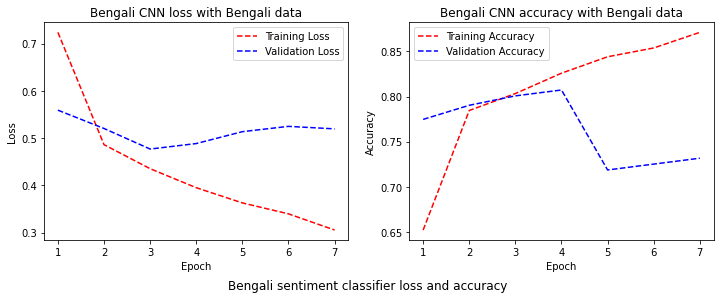

In [ ]:
epoch_count = list(range(1, len(train_loss_history)+1))
x1 = epoch_count
x2 = epoch_count
y1_train = train_loss_history
y1_val = val_loss_history
y2_train = train_acc_history
y2_val = val_acc_history

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
axes[0].plot(x1, y1_train, 'r--')
axes[0].plot(x1, y1_val, 'b--')
axes[0].legend(['Training Loss', 'Validation Loss'])
axes[0].set(xlabel='Epoch', ylabel='Loss')
axes[0].set_title('Bengali CNN loss with Bengali data')
axes[1].plot(x1, y2_train, 'r--')
axes[1].plot(x1, y2_val, 'b--')
axes[1].legend(['Training Accuracy', 'Validation Accuracy'])
axes[1].set(xlabel='Epoch', ylabel='Accuracy')
axes[1].set_title('Bengali CNN accuracy with Bengali data')
fig.suptitle('Bengali sentiment classifier loss and accuracy', y=-0.01)
plt.savefig('bengali_cnn_with_bengali_data.png')

#### Evaluation on bengali test dataset of Bengali sentiment classifier

In [ ]:
best_model_bengali_bg.eval()
test_acc_on_bengali_test_data, precision, recall, f1_score = evaluate_sentiment_classifier(best_model_bengali_bg, testloader)
print(f'Binary sentiment classification for Bengali test dataset with Bengali model: {test_acc_on_bengali_test_data*100:.2f}%')
print(f'Precision for Bengali test dataset: {precision*100:.2f}%')
print(f'Recall for Bengali test dataset: {recall*100:.2f}%')
print(f'F1 score for Bengali test dataset: {f1_score*100:.2f}%')

Binary sentiment classification for Bengali test dataset with Bengali model: 80.99%
Precision for Bengali test dataset: 82.21%
Recall for Bengali test dataset: 75.28%
F1 score for Bengali test dataset: 78.59%


## Task 2d) Part-1: Apply the classifier(Hindi Sentiment classifier) to Bengali data(Bengali Embedding that is completely unseen to the Hindi sentiment classifier). 

#### Create CNN model instance by importing CNN_BENGALI defined in task2_utils file.

In [ ]:
cnn_bengali_hi = CNN_BENGALI(input_size, embedding_size, n_filters, filter_sizes, output_dim, dropout)
cnn_bengali_hi.double()

CNN_BENGALI(
  (embedding): Linear(in_features=14325, out_features=300, bias=True)
  (conv_0): Conv2d(1, 35, kernel_size=(8, 300), stride=(1, 1))
  (conv_1): Conv2d(1, 35, kernel_size=(5, 300), stride=(1, 1))
  (conv_2): Conv2d(1, 35, kernel_size=(3, 300), stride=(1, 1))
  (fc): Linear(in_features=105, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

#### Copying the biases and embeddings of Bengali word2vec model 

In [ ]:
cnn_bengali_hi.embedding.bias.data.copy_(biases)
cnn_bengali_hi.embedding.weight.data.copy_(embeddings)

tensor([[-3.6804, -3.9742,  7.5049,  ...,  1.5165, -0.9174,  0.0000],
        [-4.4186, -4.3429,  7.0625,  ..., -0.3113,  0.1828,  0.0000],
        [ 2.6100, -3.6530,  1.7071,  ..., -0.4530,  3.2981,  0.0000],
        ...,
        [-4.0302, -3.5355, -2.8756,  ...,  4.6784, -3.8939,  0.0000],
        [-2.5204, -3.0166,  3.7221,  ..., -2.4455,  0.2383,  0.0000],
        [-4.0695,  3.5275,  3.5986,  ..., -2.3224, -2.2882,  0.0000]],
       dtype=torch.float64)

#### Copying the weights and biases from **HINDI** CNN model that is already trained for creating Bengali CNN model. That means `cnn_bengali_hi` model has Bengali word2vec as embedding layer and all other layers are from the Hindi CNN model. 

In [ ]:
cnn_bengali_hi.conv_0.bias.data.copy_(best_model_hindi.conv_0.bias)
cnn_bengali_hi.conv_0.weight.data.copy_(best_model_hindi.conv_0.weight)
cnn_bengali_hi.conv_1.bias.data.copy_(best_model_hindi.conv_1.bias)
cnn_bengali_hi.conv_1.weight.data.copy_(best_model_hindi.conv_1.weight)
cnn_bengali_hi.conv_2.bias.data.copy_(best_model_hindi.conv_2.bias)
cnn_bengali_hi.conv_2.weight.data.copy_(best_model_hindi.conv_2.weight)
cnn_bengali_hi.fc.bias.data.copy_(best_model_hindi.fc.bias)
cnn_bengali_hi.fc.weight.data.copy_(best_model_hindi.fc.weight)

tensor([[-8.5778e-02, -1.0569e-03, -5.9031e-02,  6.9597e-05,  6.3098e-02,
          9.1071e-03,  1.8070e-02,  6.1761e-02,  8.2367e-02, -1.7244e-02,
          1.5144e-02,  3.3054e-02, -6.6893e-02,  8.5354e-02,  5.9054e-02,
          1.9049e-02,  1.5450e-02,  5.8245e-02, -4.0002e-02,  6.4589e-02,
         -5.7822e-02, -1.4006e-02, -6.4809e-02, -4.9366e-02, -2.3502e-02,
         -7.4562e-02, -2.7233e-02, -3.0685e-02, -4.2813e-02,  1.5478e-02,
         -1.2585e-02,  2.2166e-02, -3.7221e-02, -8.8915e-03,  9.1954e-03,
         -5.7159e-02,  4.9921e-02,  3.7017e-02, -8.2272e-02,  2.7340e-03,
          7.7728e-02, -8.1820e-02, -2.9592e-02,  6.0386e-03,  3.0677e-03,
         -7.3146e-02,  3.7356e-02,  1.7476e-02,  6.5368e-02,  8.6268e-02,
          2.0662e-03,  8.4247e-02,  6.8383e-02,  4.6557e-02,  3.7563e-02,
          9.1041e-03, -2.4263e-02, -2.3387e-03,  2.2272e-02,  3.3217e-04,
          3.9064e-02,  8.4367e-02, -2.7172e-02,  4.3634e-02,  3.3491e-03,
         -5.9635e-03, -3.2688e-02,  5.

#### Evaluation of Sentiment classifier while Bengali embedding is used on Bengali test data while using Hindi model's weights in other layers except embedding

In [ ]:
cnn_bengali_hi.eval()
acc_of_senti_model_on_bengali_test_data_without_retrain, precision, recall, f1_score = evaluate_sentiment_classifier(cnn_bengali_hi, testloader)
print(f'Binary sentiment classification for Bengali test dataset before retraining with Bengali Data: {acc_of_senti_model_on_bengali_test_data_without_retrain*100:.2f}%')
print(f'Precision for Bengali test dataset before retraining: {precision*100:.2f}%')
print(f'Recall for Bengali test dataset before retraining: {recall*100:.2f}%')
print(f'F1 score for Bengali test dataset before retraining: {f1_score*100:.2f}%')

Binary sentiment classification for Bengali test dataset before retraining with Bengali Data: 46.74%
Precision for Bengali test dataset before retraining: 50.72%
Recall for Bengali test dataset before retraining: 99.16%
F1 score for Bengali test dataset before retraining: 67.11%


## Task 2d) Part-2: Retrain model with Bengali data

#### Define optimizer and criterion for sentiment analysis retraining

In [ ]:
optimizer = optim.Adam(cnn_bengali_hi.parameters())

criterion = nn.BCEWithLogitsLoss()

#### Retrain CNN on Bengali data 

In [ ]:
N_EPOCHS = 50
best_valid_loss = float('inf') #Initially sets to infinity
cnn_bengali_hi.train()

# Keeping loss and accuracy history of epochs for visualiztion
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

# Counter for Early stopping. Stops if no better loss for validation is achieved in 4 consecutive epochs.
stop_criterion = 0

for epoch in range(N_EPOCHS):
    #start time of the epoch
    start_time = time.time()
    
    train_loss, train_acc = train_cnn(cnn_bengali_hi, trainloader, optimizer, criterion)
    valid_loss, valid_acc = evaluate_cnn(cnn_bengali_hi, valloader, criterion)
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    val_loss_history.append(valid_loss)
    val_acc_history.append(valid_acc)

    #End time
    end_time = time.time()
    # calculate elapsed time in mins and seconds
    required_time = end_time - start_time
    mins = int(required_time / 60)
    secs = int(required_time - (mins * 60))
    
    stop_criterion += 1

    #Saving the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(cnn_bengali_hi.state_dict(), 'cnn_bengali_retrained_model.pt')
        best_model_bengali_retrained = copy.deepcopy(cnn_bengali_hi)
        stop_criterion = 0
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {mins}m {secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    if stop_criterion == 4:
      break

Epoch: 01 | Epoch Time: 0m 45s
	Train Loss: 1.025 | Train Acc: 63.60%
	 Val. Loss: 0.590 |  Val. Acc: 64.32%
Epoch: 02 | Epoch Time: 0m 45s
	Train Loss: 0.497 | Train Acc: 77.12%
	 Val. Loss: 0.514 |  Val. Acc: 79.17%
Epoch: 03 | Epoch Time: 0m 45s
	Train Loss: 0.433 | Train Acc: 80.70%
	 Val. Loss: 0.516 |  Val. Acc: 71.35%
Epoch: 04 | Epoch Time: 0m 45s
	Train Loss: 0.393 | Train Acc: 83.34%
	 Val. Loss: 0.517 |  Val. Acc: 72.53%
Epoch: 05 | Epoch Time: 0m 45s
	Train Loss: 0.366 | Train Acc: 84.09%
	 Val. Loss: 0.493 |  Val. Acc: 80.99%
Epoch: 06 | Epoch Time: 0m 45s
	Train Loss: 0.318 | Train Acc: 86.99%
	 Val. Loss: 0.514 |  Val. Acc: 72.66%
Epoch: 07 | Epoch Time: 0m 45s
	Train Loss: 0.299 | Train Acc: 87.86%
	 Val. Loss: 0.506 |  Val. Acc: 71.74%
Epoch: 08 | Epoch Time: 0m 45s
	Train Loss: 0.263 | Train Acc: 89.22%
	 Val. Loss: 0.517 |  Val. Acc: 79.82%
Epoch: 09 | Epoch Time: 0m 45s
	Train Loss: 0.248 | Train Acc: 90.04%
	 Val. Loss: 0.525 |  Val. Acc: 72.79%


#### Visualize Loss and Accuracy for the model with Bengali dataset after retraining

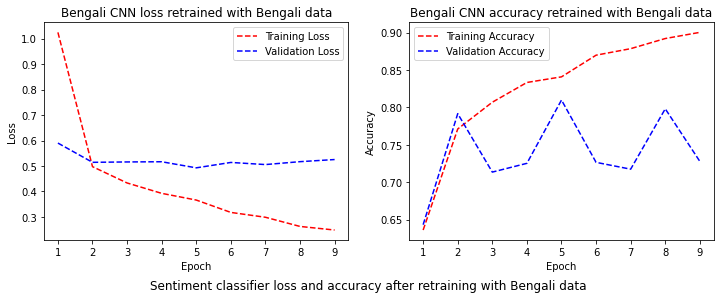

In [ ]:
epoch_count = list(range(1, len(train_loss_history)+1))
x1 = epoch_count
x2 = epoch_count
y1_train = train_loss_history
y1_val = val_loss_history
y2_train = train_acc_history
y2_val = val_acc_history

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
axes[0].plot(x1, y1_train, 'r--')
axes[0].plot(x1, y1_val, 'b--')
axes[0].legend(['Training Loss', 'Validation Loss'])
axes[0].set(xlabel='Epoch', ylabel='Loss')
axes[0].set_title('Bengali CNN loss retrained with Bengali data')
axes[1].plot(x1, y2_train, 'r--')
axes[1].plot(x1, y2_val, 'b--')
axes[1].legend(['Training Accuracy', 'Validation Accuracy'])
axes[1].set(xlabel='Epoch', ylabel='Accuracy')
axes[1].set_title('Bengali CNN accuracy retrained with Bengali data')
fig.suptitle('Sentiment classifier loss and accuracy after retraining with Bengali data', y=-0.01)
plt.savefig('bengali_cnn_after_retrained.png')

#### Evaluation on bengali test dataset of Sentiment classifier after retraining with bengali Embedding

In [ ]:
best_model_bengali_retrained.eval()
test_acc_on_bengali_test_data_retrained, precision, recall, f1_score = evaluate_sentiment_classifier(best_model_bengali_retrained, testloader)
print(f'Binary sentiment classification for Bengali test dataset after retraining: {test_acc_on_bengali_test_data_retrained*100:.2f}%')
print(f'Precision for Bengali test dataset after retraining: {precision*100:.2f}%')
print(f'Recall for Bengali test dataset after retraining: {recall*100:.2f}%')
print(f'F1 score for Bengali test dataset after retraining: {f1_score*100:.2f}%')

Binary sentiment classification for Bengali test dataset after retraining: 81.77%
Precision for Bengali test dataset after retraining: 82.53%
Recall for Bengali test dataset after retraining: 76.97%
F1 score for Bengali test dataset after retraining: 79.65%
